In [1]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train

# train and test that consider only variable temperature 
%store -r train_t
%store -r test_t

# deseasonal series 
%store -r w_train_seas_diff

## Seasonal ARIMA

A seasonal ARIMA model (SARIMA) is made by including additional seasonal terms in the models we have seen so far.

These are generally written as ARIMA(p,d,q)(P,D,Q)m where the first part (p,d,q) refers to the non-seasonal component, while the second one (P,D,Q)m to the seasonal component. The term m refers to the seasonality (seasonal period, e.g., for annual data m = 12, quarterly data m = 4). This is also indicated as S (or s).

CF and PACF plots can help in identifying not only the non-seasonal component but also the seasonal part of an AR or MA model by looking at the seasonal lags of the PACF and ACF. For example:

* ARIMA(0,0,0)(0,0,1)12: 1) a significant spike at lag 12 in the ACF but no other significant spikes; 2) exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36);
* ARIMA(0,0,0)(1,0,0)12: 1) exponential decay in the seasonal lags of the ACF; 2) a single significant spike at lag 12 in the PACF.

## PACKAGES

In [2]:
import numpy as np
import pandas as pd
import statsmodels.datasets as smd
import sklearn
import scipy.stats as stats
from scipy import signal
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')


# Specific importing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#! pip install pmdarima
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [3]:
# ACCURACY DF FOR SARIMA MODEL
accuracy_SARIMA_df = pd.DataFrame(columns=['Model','AIC','RMSE','MAE'])

## ACF and PACF - Seasonal/Deseasonal 

Before apllying the automatic models we want to try to understand which models could be the best one, and the best parameters (p,d,q)(P,D,Q), observing the ACF and the PACF.

REMARK:

* MA(q): 
- ACF decrease fast to zero
- PACF slowly decrease to zero 

* AR(p)
- ACF decrease slowly to zero
- PACF decrease fast to zero 

* NON SEASONAL COMPONENT:
**BEFORE THE SEASONAL LAG**
* SEASONAL COMPONENT:
**AFTER THE SEASONAL LAG** and multiples

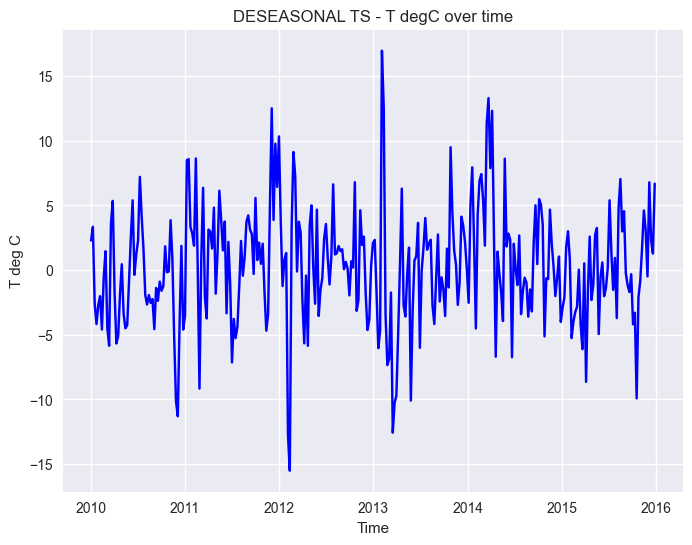

In [4]:
#ts 
plt.figure(figsize=(8,6))
plt.plot(w_train_seas_diff,color='Blue')
plt.xlabel('Time')
plt.ylabel('T deg C')
plt.title('DESEASONAL TS - T degC over time')
plt.show()

In [5]:
# we have to remove null values
w_train_seas_diff.dropna(inplace=True)

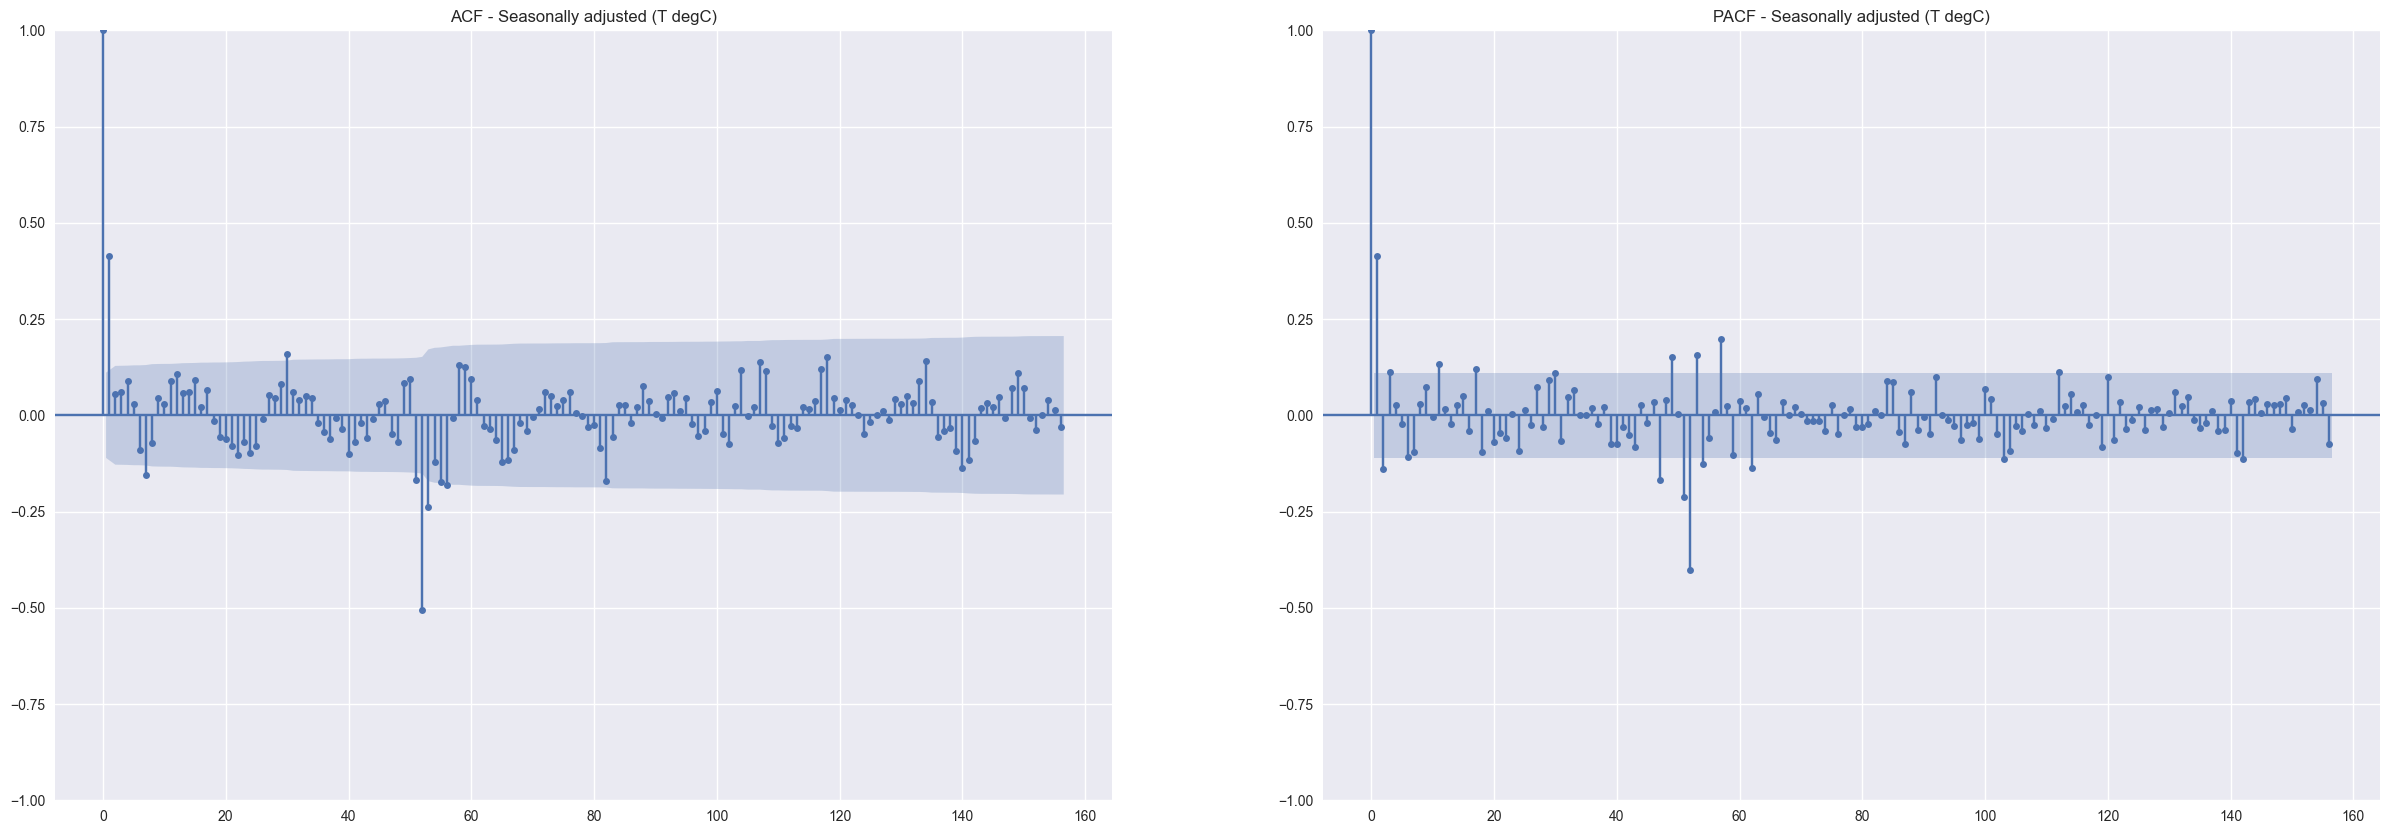

In [6]:
# ACF and PACF plot
fig, ax = plt.subplots(1, 2, figsize=(30,10))
plot_acf(w_train_seas_diff, lags=156, ax=ax[0], title='ACF - Seasonally adjusted (T degC)')
plot_pacf(w_train_seas_diff, lags=156, ax=ax[1], title='PACF - Seasonally adjusted (T degC)')
plt.show()

From the observation of this ACF and PACF, we can say:

* **NON SEASONAL PART - before the 52 lag:** Looking ACF: we have 3 significative peack, and the other lags decrease fast to zero; so we can individuate a MA(3) component. 
Looking PACF: the lags fast decrease to 0,  and we have 1 or 3 significant lag, so we can see a AR(1) or AR(3).

--> ITEGRATED PART = 0, since out series is stationary, we don't have to delite a long term component.

* **SEASONAL PART - after the 52 lag (with period 52):** Looking ACF: we have 1 OR 2 significan component and again the other lags goes faster to zero, so we can try with MA(1) or MA(2) .
Looking PACF: 1 or 2 significanl lags, so we can try with AR(1) or AR(2). 

--> INTEGRATED PART = 1, since we have to apply the seasonal differantiation 

So we can try to implement models, trying different parameters: 

* 1) **Manual SARIMA(1,0,3)(1,1,2) m=52**

* 2) **Manual SARIMA(3,0,1)(1,1,1) m=52**



## MANUAL SARIMA

So we build the model linked to what we find looking the ACF and PACF above

### 1) **Manual SARIMA(1,0,3)(1,1,2) m=52**

In [7]:
# DEFINITION OF THE PARAMETERS 
(p,d,q)=(1,0,3)
(P,D,Q,S)=(1,1,2,52)

In [8]:
# fit the model
SARIMA_model_manual = SARIMAX(train_t, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
SARIMA_model_manual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                T (degC)   No. Observations:                  365
Model:             SARIMAX(1, 0, 3)x(1, 1, [1, 2], 52)   Log Likelihood                -824.777
Date:                                 Wed, 29 Jan 2025   AIC                           1665.554
Time:                                         17:00:26   BIC                           1695.523
Sample:                                     01-04-2009   HQIC                          1677.530
                                          - 12-27-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2219      0.500     -0.444      0.657      -1.201       0.757
ma.L1          0.7132      0.491      1.453      0.146      -0.249       1.675
ma.L2          0.2142      0.237      0.905      0.365      -0.250       0.678
ma.L3          0.1195      0.062      1.942      0.052      -0.001       0.240
ar.S.L52      -0.5711      0.435     -1.312      0.189      -1.424       0.282
ma.S.L52      -0.1316      0.442     -0.298      0.766      -0.998       0.734
ma.S.L104     -0.2263      0.329     -0.688      0.492      -0.871       0.419
sigma2        10.4482      0.760     13.749      0.000       8.959      11.938
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                17.35
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.05
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

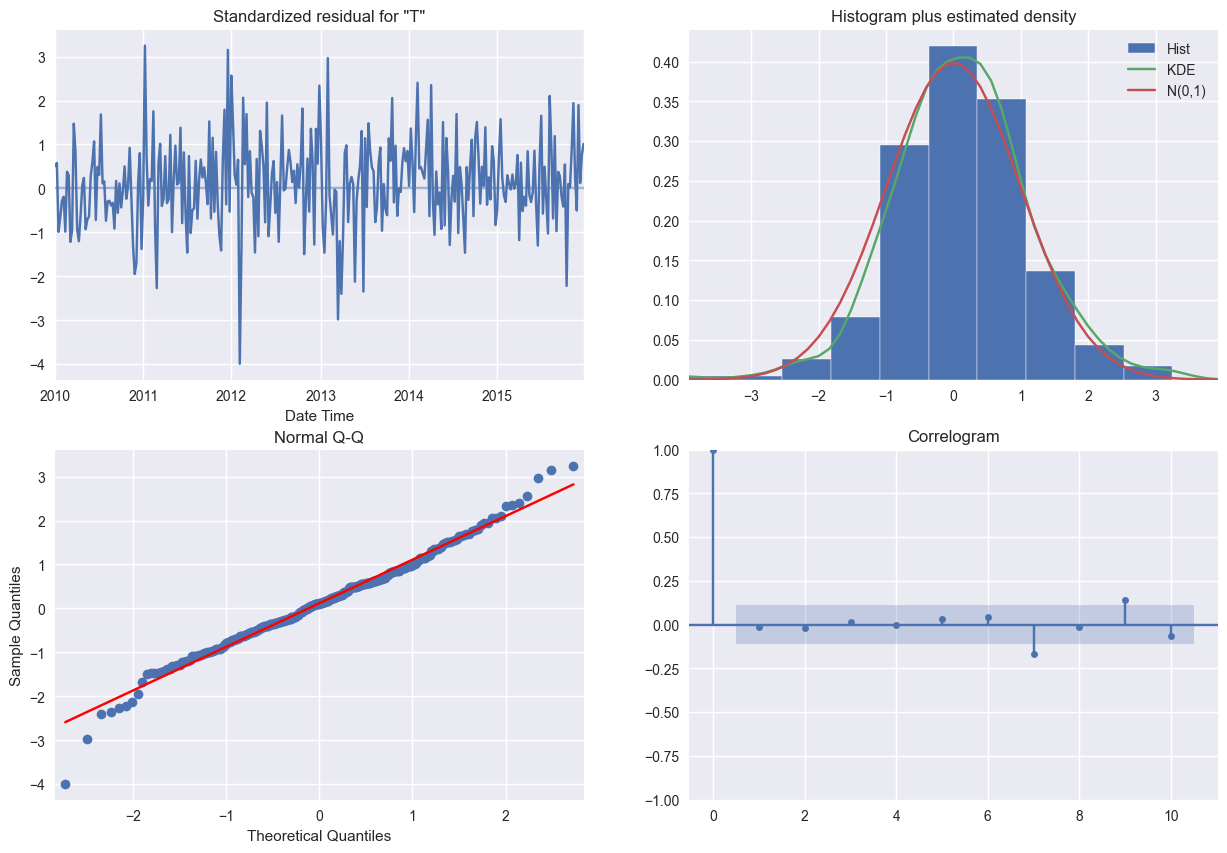

In [9]:
# visualize the results of the model
SARIMA_model_manual.plot_diagnostics(figsize=(15,10))
plt.show()

**Residual diagnostics of a SARIMA1 model**

The SARIMA model seems to have captured the structure of the time series fairly well, as the residuals appear random and show little autocorrelation.  
However, there are some extreme values and slight deviations from normality, particularly in the tails of the distribution.

### FORECAST SARIMA manual

In [10]:
SARIMA_model_manual_pred = SARIMA_model_manual.get_prediction(start=test_t.index[0], end=test_t.index[-1])
#summary of the model
SARIMA_model_manual_pred_df = SARIMA_model_manual_pred.summary_frame()
#take the forecasting
SARIMA_forecast = SARIMA_model_manual_pred_df['mean']

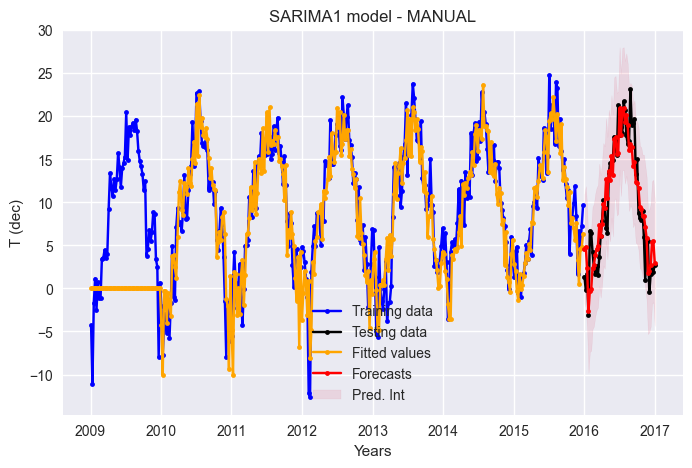

In [11]:
# PLOT
plt.figure(figsize=(8,5))
plt.plot((train_t), color='blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot((SARIMA_model_manual.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(SARIMA_forecast, color='red', marker = '.', label='Forecasts')
plt.fill_between(SARIMA_model_manual_pred_df.index, SARIMA_model_manual_pred_df['mean_ci_lower'], SARIMA_model_manual_pred_df['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('SARIMA1 model - MANUAL')
plt.legend()
plt.show()

In [12]:
accuracy_SARIMA_df = pd.concat([accuracy_SARIMA_df, pd.DataFrame({'Model':'MANUAL SARIMA1', 'AIC':SARIMA_model_manual.aic, 'RMSE':root_mean_squared_error(test_t, SARIMA_model_manual_pred_df['mean']), 'MAE':mean_absolute_error(test_t, SARIMA_model_manual_pred_df['mean'])},index=[0])], ignore_index=True)

### 2) **Manual SARIMA(3,0,1)(1,1,1) m=52**

In [13]:
# DEFINITION OF THE PARAMETERS 
(p,d,q)=(3,0,1)
(P,D,Q,S)=(1,1,1,52)

In [14]:
# fit the model
SARIMA_model_manual_2 = SARIMAX(train_t, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
SARIMA_model_manual_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -825.163
Date:                            Wed, 29 Jan 2025   AIC                           1664.327
Time:                                    17:01:08   BIC                           1690.550
Sample:                                01-04-2009   HQIC                          1674.806
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      0.295     -0.346      0.729      -0.680       0.476
ar.L2          0.1377      0.146      0.943      0.346      -0.149       0.424
ar.L3          0.0617      0.079      0.781      0.435      -0.093       0.217
ma.L1          0.5876      0.286      2.056      0.040       0.027       1.148
ar.S.L52      -0.2421      0.104     -2.328      0.020      -0.446      -0.038
ma.S.L52      -0.4536      0.114     -3.976      0.000      -0.677      -0.230
sigma2        10.4952      0.724     14.501      0.000       9.077      11.914
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                18.57
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.06
Prob(H) (two-sided):                  0.68   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

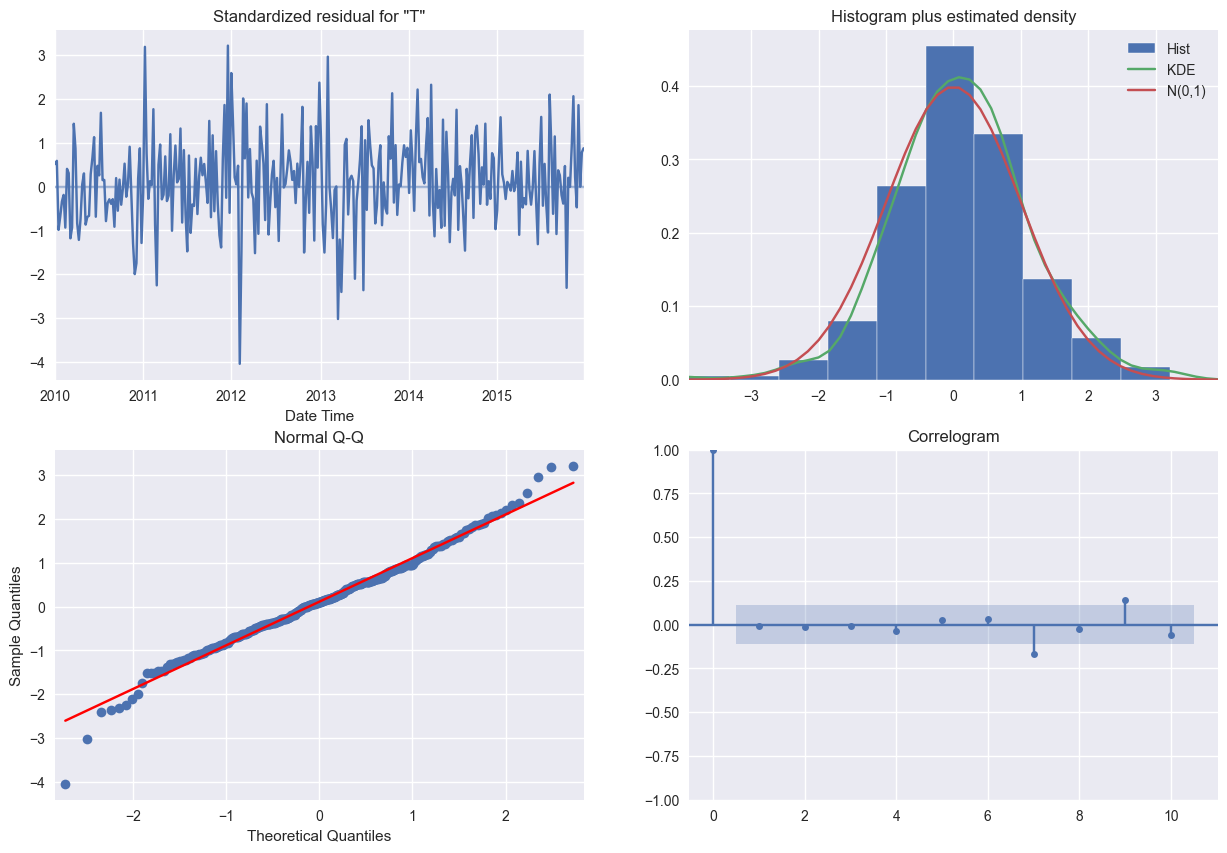

In [15]:
# visualize the results of the model
SARIMA_model_manual_2.plot_diagnostics(figsize=(15,10))
plt.show()

**Residual diagnostics of a SARIMA2 model**

The SARIMA model seems to have captured the structure of the time series fairly well, as the residuals appear random and show little autocorrelation.  
However, there are some extreme values and slight deviations from normality, particularly in the tails of the distribution.

### FORECAST MANUAL SARIMA 2

In [16]:
SARIMA_model_manual_pred_2 = SARIMA_model_manual_2.get_prediction(start=test_t.index[0], end=test_t.index[-1])
#summary of the model
SARIMA_model_manual_pred_df_2 = SARIMA_model_manual_pred_2.summary_frame()
#take the forecasting
SARIMA_forecast_2 = SARIMA_model_manual_pred_df_2['mean']

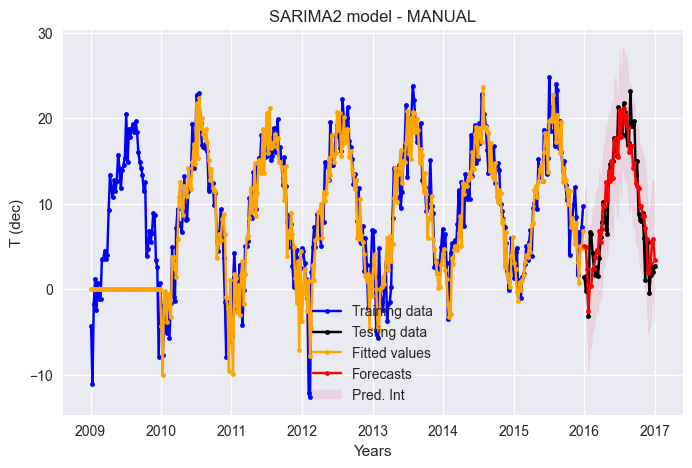

In [17]:
# PLOT
plt.figure(figsize=(8,5))
plt.plot((train_t), color='blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot((SARIMA_model_manual_2.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(SARIMA_forecast_2, color='red', marker = '.', label='Forecasts')
plt.fill_between(SARIMA_model_manual_pred_df_2.index, SARIMA_model_manual_pred_df_2['mean_ci_lower'], SARIMA_model_manual_pred_df_2['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('SARIMA2 model - MANUAL')
plt.legend()
plt.show()

In [18]:
accuracy_SARIMA_df = pd.concat([accuracy_SARIMA_df, pd.DataFrame({'Model':'MANUAL SARIMA2', 'AIC':SARIMA_model_manual_2.aic, 'RMSE':root_mean_squared_error(test_t, SARIMA_model_manual_pred_df_2['mean']), 'MAE':mean_absolute_error(test_t, SARIMA_model_manual_pred_df_2['mean'])},index=[0])], ignore_index=True)

## AUTO SARIMA

Now our aim is to see if using an automathic procedure, we are able to improve the model that we defive above, find better parameters (p,d,q)(P,D,Q,S) 

In [19]:
'''
stepwise_SARIMAmodel = auto_arima(train_t, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=52,
                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True) ''' 

"\nstepwise_SARIMAmodel = auto_arima(train_t, start_p=0, start_q=0, d=0,\n                           max_p=5, max_q=5, m=52,\n                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,\n                           trace=True, information_criterion='aic',\n                           error_action='ignore',\n                           suppress_warnings=True,\n                           stepwise=True) "

In [20]:
# we try to fit the model with the parameters that AUTO ARIMA give us
(p,d,q)=(3,0,0)
(P,D,Q,S)=(2,0,0,52)

# fit the model
SARIMA_model_auto = SARIMAX(train_t, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
SARIMA_model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -956.476
Date:                            Wed, 29 Jan 2025   AIC                           1924.952
Time:                                    17:01:34   BIC                           1948.352
Sample:                                01-04-2009   HQIC                          1934.252
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7058      0.050     14.106      0.000       0.608       0.804
ar.L2          0.0125      0.063      0.198      0.843      -0.111       0.136
ar.L3          0.2295      0.045      5.049      0.000       0.140       0.319
ar.S.L52       0.1494      0.051      2.948      0.003       0.050       0.249
ar.S.L104      0.2181      0.057      3.843      0.000       0.107       0.329
sigma2        10.7842      0.679     15.877      0.000       9.453      12.115
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.61
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.09
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

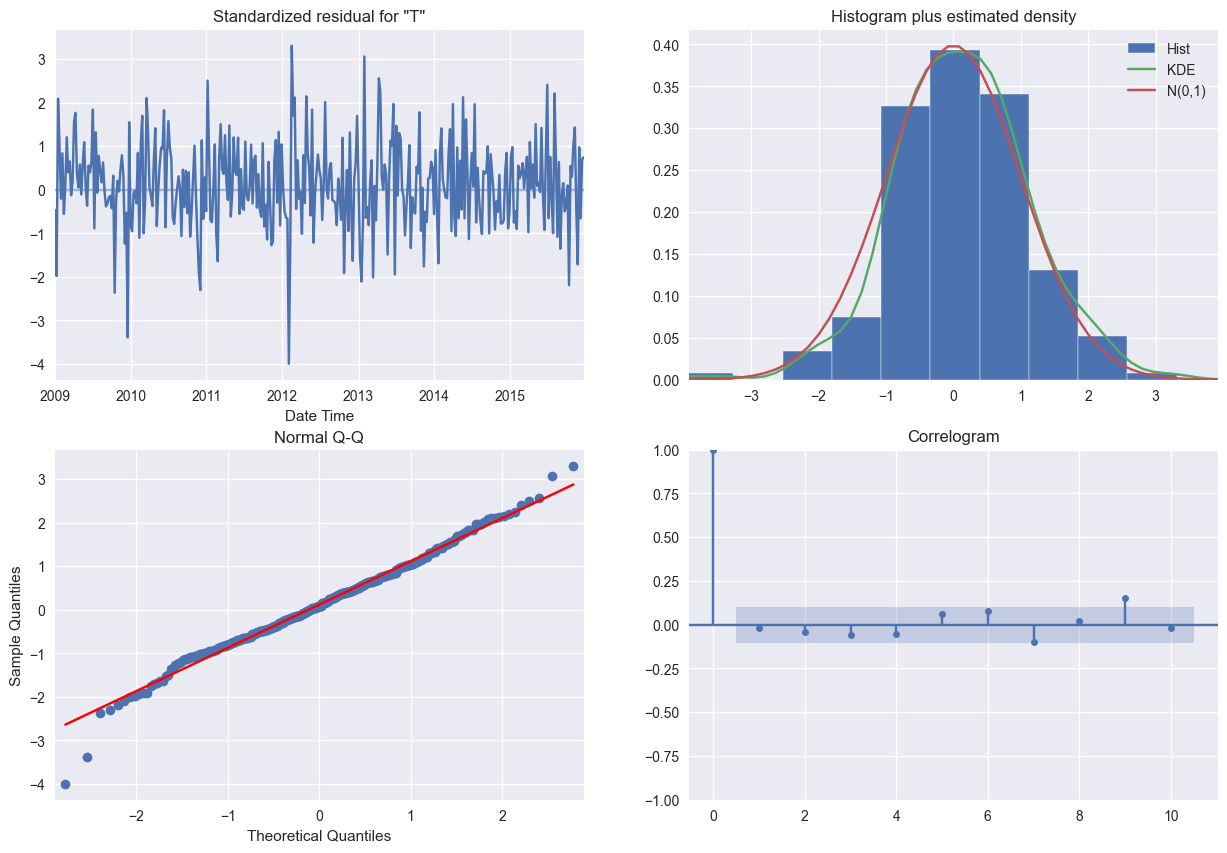

In [21]:
# visualize the results of the model
SARIMA_model_auto.plot_diagnostics(figsize=(15,10))
plt.show()

**Residual diagnostics of a AUTO SARIMA model**

The AUTO SARIMA model seems to have captured the structure of the time series fairly well, as the residuals appear random and show little autocorrelation.  
However, there are some extreme values and slight deviations from normality, particularly in the tails of the distribution.

### FORECAST SARIMA AUTO

In [22]:
SARIMA_model_auto_pred = SARIMA_model_auto.get_prediction(start=test_t.index[0], end=test_t.index[-1])
#summary of the model
SARIMA_model_auto_pred_df = SARIMA_model_auto_pred.summary_frame()
#take the forecasting
SARIMA_auto_forecast = SARIMA_model_auto_pred_df['mean']

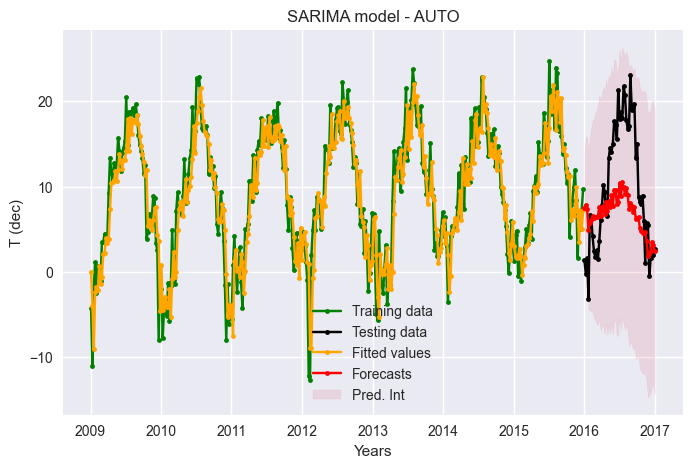

In [23]:
# PLOT
plt.figure(figsize=(8,5))
plt.plot((train_t), color='green',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot((SARIMA_model_auto.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(SARIMA_auto_forecast, color='red', marker = '.', label='Forecasts')
plt.fill_between(SARIMA_model_auto_pred_df.index, SARIMA_model_auto_pred_df['mean_ci_lower'], SARIMA_model_auto_pred_df['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('SARIMA model - AUTO')
plt.legend()
plt.show()

In [24]:
accuracy_SARIMA_df = pd.concat([accuracy_SARIMA_df, pd.DataFrame({'Model':'AUTO SARIMA', 'AIC':SARIMA_model_auto.aic, 'RMSE':root_mean_squared_error(test_t, SARIMA_model_auto_pred_df['mean']), 'MAE':mean_absolute_error(test_t, SARIMA_model_auto_pred_df['mean'])},index=[0])], ignore_index=True)

## **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model 


is an extension of the ARIMA model that includes seasonal components and exogenous regressors to capture complex relationships in temporal data.

An exogenous regressor is a variable X_{t} which is added to the SARIMAX model to improve the prediction of the dependent variable y_{t}.

We must avoid using exogenous variables that are too correlated in order to avoid problems of multicollinearity and overfitting.

### EXOGENOUS VARIABLES definition - HEATMAP 

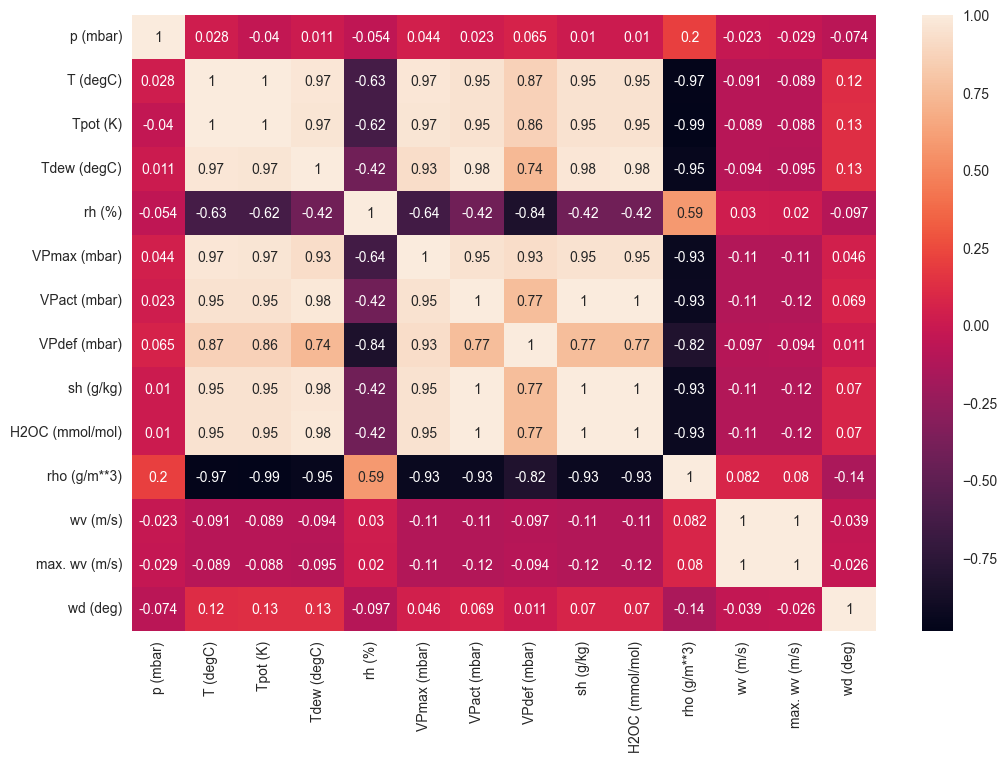

In [25]:
## HEATMAP 
features=['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']

plt.figure(figsize=(12,8))
sns.heatmap(w_df[features].corr(),annot=True)
plt.show()

From the obseration of the heatmap, we can notice:

High correlated variables with T deg C are:

**POSITIVE CORRELATION** 
* Tpot (K): 0.99
* Tdew (degC), VPmax (mbar), VPact (mbar), H2OC (mmol/mol), e sh (g/kg): (>0.94)
* VPdef (mbar): 0.86

**NEGATIVE CORRELATION**
* rho (g/m³): −0.97
* rh (%): −0.62

**LOW CORRELATION**
* wd (deg), p (mbar), wv (m/s), e max. wv (m/s)

From this we can chose as **EXOGENOUS VARIABLES**:

* Exclude Tpot (K) since can be redundant with T (degC).
* Include variables as Tdew (degC), VPmax (mbar), e rho (g/m³).
* We can also use variables as VPact (mbar) o sh (g/kg) based on the results that i obtain fron the model.

In [26]:
# definition of the exogen variables
exog_v = ['Tdew (degC)', 'VPmax (mbar)', 'rho (g/m**3)']
train_exo = w_df[w_df.index < '2016-01-01'][exog_v]
test_exo = w_df[w_df.index >= '2016-01-01'][exog_v]

# and we also have to use train_t and text_t in which we have variable T deg C

In [27]:
# we have also to define the parameter of the model
# i decide to use the one that provide the less MAE 
# The one of the MANUAL SARIMA 
(p,d,q)=(1,0,3)
(P,D,Q,S)=(1,1,2,52)

In [28]:
SARIMAX_model = SARIMAX(train_t,
                        order = (p,d,q),
                        seasonal_order= (P, D, Q, S),
                        exog=train_exo).fit()

In [29]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                T (degC)   No. Observations:                  365
Model:             SARIMAX(1, 0, 3)x(1, 1, [1, 2], 52)   Log Likelihood                -386.440
Date:                                 Wed, 29 Jan 2025   AIC                            794.879
Time:                                         17:04:56   BIC                            836.087
Sample:                                     01-04-2009   HQIC                           811.347
                                          - 12-27-2015                                         
Covariance Type:                                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Tdew (degC)      0.4016      0.024     16.637      0.000       0.354       0.449
VPmax (mbar)     0.4685      0.021     22.453      0.000       0.428       0.509
rho (g/m**3)    -0.0496      0.004    -11.833      0.000      -0.058      -0.041
ar.L1            0.5485      0.213      2.575      0.010       0.131       0.966
ma.L1           -0.1588      0.214     -0.741      0.458      -0.579       0.261
ma.L2           -0.0216      0.098     -0.220      0.826      -0.214       0.171
ma.L3            0.0959      0.069      1.395      0.163      -0.039       0.231
ar.S.L52        -0.3808      3.812     -0.100      0.920      -7.852       7.090
ma.S.L52        -0.3833      3.794     -0.101      0.920      -7.820       7.053
ma.S.L104       -0.2689      2.930     -0.092      0.927      -6.012       5.475
sigma2           0.6032      0.069      8.718      0.000       0.468       0.739
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.98
Prob(Q):                              0.93   Prob(JB):                         0.23
Heteroskedasticity (H):               0.86   Skew:                            -0.13
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

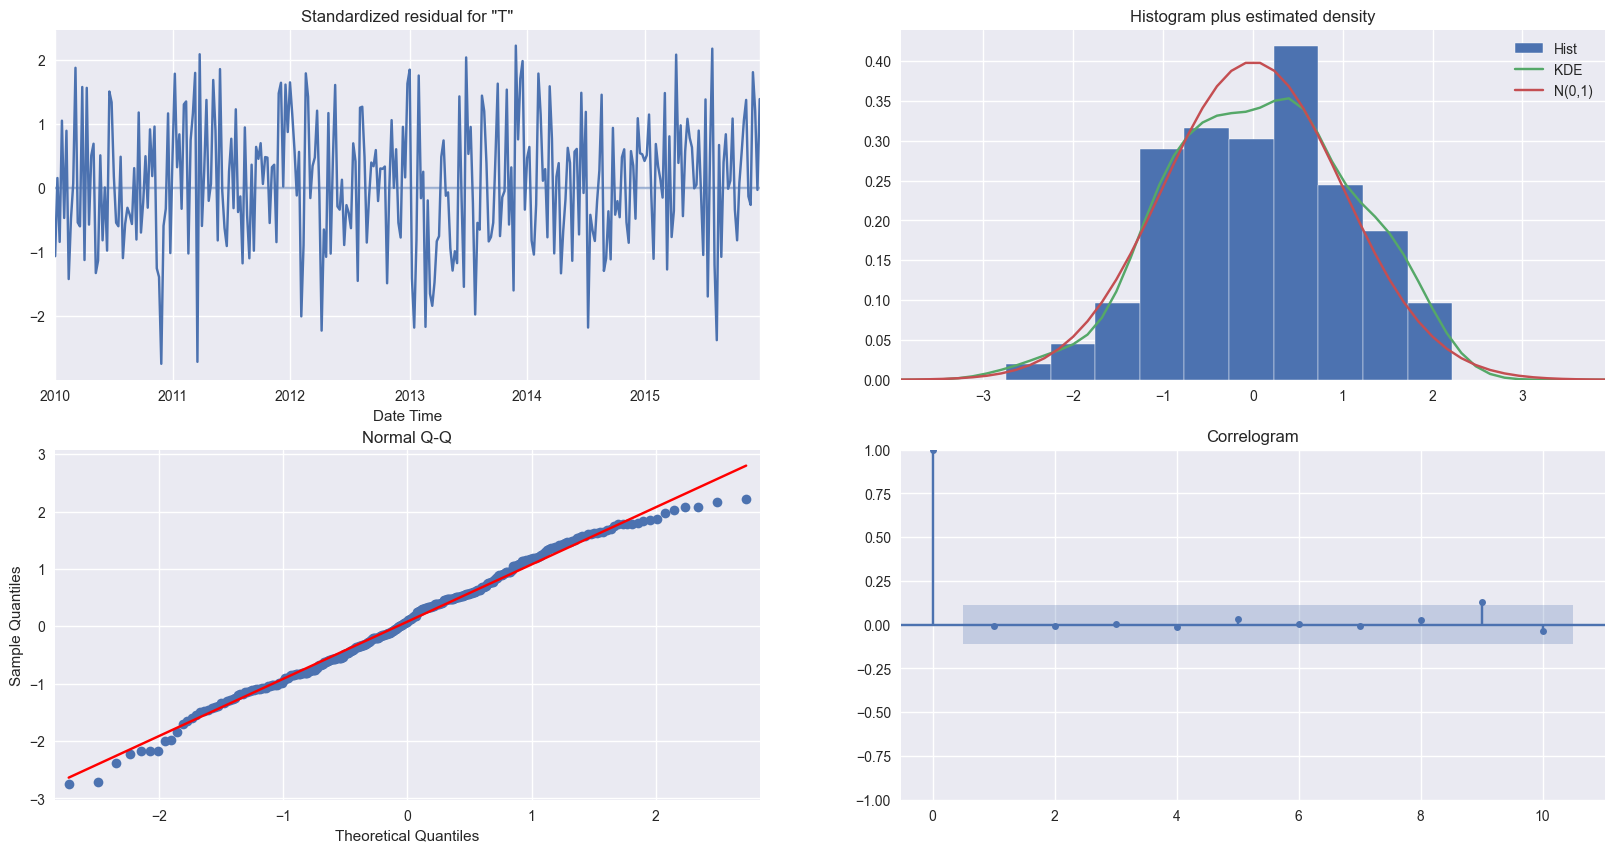

In [30]:
SARIMAX_model.plot_diagnostics(figsize=(20,10))
plt.show()

**Residual diagnostics of a SARIMAX model**

The SARIMAX model seems to have captured the structure of the time series fairly well, as the residuals appear random and show little autocorrelation.  
However, there are some extreme values and slight deviations from normality, particularly in the tails of the distribution and also we can see some problems in the density histogram that does not follow really well the Normal distribution also in the peack of the distribution.

## FORECAST SARIMAX MODEL 

In [31]:
SARIMAX_model_pred = SARIMAX_model.get_prediction(start=test_t.index[0], end=test_t.index[-1],exog=test_exo)
#summary of the model
SARIMAX_model_pred_df = SARIMAX_model_pred.summary_frame()
#take the forecasting
SARIMAX_forecast = SARIMAX_model_pred_df['mean']

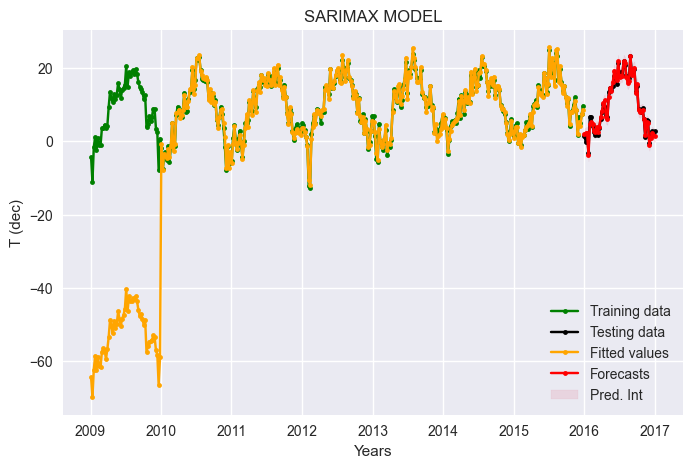

In [32]:
plt.figure(figsize=(8,5))
plt.plot((train_t), color='green',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot((SARIMAX_model.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(SARIMAX_forecast, color='red', marker = '.', label='Forecasts')
plt.fill_between(SARIMAX_model_pred_df.index, SARIMAX_model_pred_df['mean_ci_lower'], SARIMAX_model_pred_df['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('SARIMAX MODEL')
plt.legend()
plt.show()

# CREDO DI SIA QUALCOSA CHE NON VA 

In [33]:
accuracy_SARIMA_df = pd.concat([accuracy_SARIMA_df, pd.DataFrame({'Model':'SARIMAX', 'AIC':SARIMAX_model.aic, 'RMSE':root_mean_squared_error(test_t, SARIMAX_model_pred_df['mean']), 'MAE':mean_absolute_error(test_t, SARIMAX_model_pred_df['mean'])},index=[0])], ignore_index=True)

## ACCURACY 

In [34]:
accuracy_SARIMA_df

,Model,AIC,RMSE,MAE
0,MANUAL SARIMA1,1665.553559,3.030239,2.337369
1,MANUAL SARIMA2,1664.326742,3.017154,2.375053
2,AUTO SARIMA,1924.952285,6.703734,5.489236
3,SARIMAX,794.879223,0.816593,0.643702


**CONCLUSION**

We can conclude saying that the **best models that we have obtain are the MANUAL SARIMA's and the SARIMAX**.

The main problem of the AUTO SARIMA is given by the fact that does not take in consideration the **SEASONAL DIFFERENTIATION**, this inevitably compromise the results, as we can also see from the forecasr graph where it not be able to capture the seasonal behaviour.

I also want to add, that from the residual behaviour we can see that we have in the tails some extrime values, so in order to improve the models maybe can fix it using some tranformation (for example the log one).